# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3145728/11490434 [=======>......................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:11 - loss: 0.6930

  35/1875 [..............................] - ETA: 2s - loss: 0.5209   

  72/1875 [>.............................] - ETA: 2s - loss: 0.4404

 110/1875 [>.............................] - ETA: 2s - loss: 0.3999

 146/1875 [=>............................] - ETA: 2s - loss: 0.3755

 177/1875 [=>............................] - ETA: 2s - loss: 0.3596

 213/1875 [==>...........................] - ETA: 2s - loss: 0.3449

 245/1875 [==>...........................] - ETA: 2s - loss: 0.3339

 277/1875 [===>..........................] - ETA: 2s - loss: 0.3245

 310/1875 [===>..........................] - ETA: 2s - loss: 0.3160

 349/1875 [====>.........................] - ETA: 2s - loss: 0.3072

 388/1875 [=====>........................] - ETA: 2s - loss: 0.2995

 423/1875 [=====>........................] - ETA: 2s - loss: 0.2934

 462/1875 [======>.......................] - ETA: 2s - loss: 0.2872

 500/1875 [=======>......................] - ETA: 1s - loss: 0.2817

 538/1875 [=======>......................] - ETA: 1s - loss: 0.2767

 576/1875 [========>.....................] - ETA: 1s - loss: 0.2721

 613/1875 [========>.....................] - ETA: 1s - loss: 0.2680

 644/1875 [=========>....................] - ETA: 1s - loss: 0.2647

 679/1875 [=========>....................] - ETA: 1s - loss: 0.2613

 713/1875 [==========>...................] - ETA: 1s - loss: 0.2581

 741/1875 [==========>...................] - ETA: 1s - loss: 0.2556

 773/1875 [===========>..................] - ETA: 1s - loss: 0.2529

 811/1875 [===========>..................] - ETA: 1s - loss: 0.2499

 848/1875 [============>.................] - ETA: 1s - loss: 0.2471

 879/1875 [=============>................] - ETA: 1s - loss: 0.2449

 910/1875 [=============>................] - ETA: 1s - loss: 0.2428

 939/1875 [==============>...............] - ETA: 1s - loss: 0.2408

 971/1875 [==============>...............] - ETA: 1s - loss: 0.2388

1003/1875 [===============>..............] - ETA: 1s - loss: 0.2368

1033/1875 [===============>..............] - ETA: 1s - loss: 0.2351

1063/1875 [================>.............] - ETA: 1s - loss: 0.2334

1098/1875 [================>.............] - ETA: 1s - loss: 0.2315

1130/1875 [=================>............] - ETA: 1s - loss: 0.2298

1162/1875 [=================>............] - ETA: 1s - loss: 0.2281

1199/1875 [==================>...........] - ETA: 1s - loss: 0.2263

1237/1875 [==================>...........] - ETA: 0s - loss: 0.2245

1276/1875 [===================>..........] - ETA: 0s - loss: 0.2227

1313/1875 [====================>.........] - ETA: 0s - loss: 0.2211

1342/1875 [====================>.........] - ETA: 0s - loss: 0.2199

1379/1875 [=====================>........] - ETA: 0s - loss: 0.2183

1415/1875 [=====================>........] - ETA: 0s - loss: 0.2169

1452/1875 [======================>.......] - ETA: 0s - loss: 0.2155

1490/1875 [======================>.......] - ETA: 0s - loss: 0.2140

1529/1875 [=======================>......] - ETA: 0s - loss: 0.2126

1568/1875 [========================>.....] - ETA: 0s - loss: 0.2113

1604/1875 [========================>.....] - ETA: 0s - loss: 0.2100

1641/1875 [=========================>....] - ETA: 0s - loss: 0.2088

1679/1875 [=========================>....] - ETA: 0s - loss: 0.2076

1707/1875 [==========================>...] - ETA: 0s - loss: 0.2067

1738/1875 [==========================>...] - ETA: 0s - loss: 0.2057

1769/1875 [===========================>..] - ETA: 0s - loss: 0.2048

1800/1875 [===========================>..] - ETA: 0s - loss: 0.2039

1828/1875 [============================>.] - ETA: 0s - loss: 0.2031

1856/1875 [============================>.] - ETA: 0s - loss: 0.2023

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2017


Epoch 2/5
   1/1875 [..............................] - ETA: 9s - loss: 0.1245

  27/1875 [..............................] - ETA: 3s - loss: 0.1142

  56/1875 [..............................] - ETA: 3s - loss: 0.1130

  83/1875 [>.............................] - ETA: 3s - loss: 0.1125

 111/1875 [>.............................] - ETA: 3s - loss: 0.1122

 140/1875 [=>............................] - ETA: 3s - loss: 0.1120

 161/1875 [=>............................] - ETA: 3s - loss: 0.1119

 189/1875 [==>...........................] - ETA: 3s - loss: 0.1117

 216/1875 [==>...........................] - ETA: 3s - loss: 0.1116

 244/1875 [==>...........................] - ETA: 3s - loss: 0.1114

 279/1875 [===>..........................] - ETA: 2s - loss: 0.1112

 309/1875 [===>..........................] - ETA: 2s - loss: 0.1111

 331/1875 [====>.........................] - ETA: 2s - loss: 0.1110

 359/1875 [====>.........................] - ETA: 2s - loss: 0.1108

 385/1875 [=====>........................] - ETA: 2s - loss: 0.1107

 412/1875 [=====>........................] - ETA: 2s - loss: 0.1106

 440/1875 [======>.......................] - ETA: 2s - loss: 0.1105

 472/1875 [======>.......................] - ETA: 2s - loss: 0.1103

 501/1875 [=======>......................] - ETA: 2s - loss: 0.1102

 530/1875 [=======>......................] - ETA: 2s - loss: 0.1101

 563/1875 [========>.....................] - ETA: 2s - loss: 0.1100

 594/1875 [========>.....................] - ETA: 2s - loss: 0.1098

 626/1875 [=========>....................] - ETA: 2s - loss: 0.1097

 653/1875 [=========>....................] - ETA: 2s - loss: 0.1096

 682/1875 [=========>....................] - ETA: 2s - loss: 0.1095

 710/1875 [==========>...................] - ETA: 2s - loss: 0.1094

 733/1875 [==========>...................] - ETA: 2s - loss: 0.1094

 760/1875 [===========>..................] - ETA: 2s - loss: 0.1093

 790/1875 [===========>..................] - ETA: 1s - loss: 0.1092

 813/1875 [============>.................] - ETA: 1s - loss: 0.1091

 840/1875 [============>.................] - ETA: 1s - loss: 0.1090

 866/1875 [============>.................] - ETA: 1s - loss: 0.1089

 895/1875 [=============>................] - ETA: 1s - loss: 0.1089

 925/1875 [=============>................] - ETA: 1s - loss: 0.1088

 955/1875 [==============>...............] - ETA: 1s - loss: 0.1087

 985/1875 [==============>...............] - ETA: 1s - loss: 0.1086

1016/1875 [===============>..............] - ETA: 1s - loss: 0.1085

1048/1875 [===============>..............] - ETA: 1s - loss: 0.1084

1080/1875 [================>.............] - ETA: 1s - loss: 0.1083

1112/1875 [================>.............] - ETA: 1s - loss: 0.1083

1136/1875 [=================>............] - ETA: 1s - loss: 0.1082

1165/1875 [=================>............] - ETA: 1s - loss: 0.1081

1195/1875 [==================>...........] - ETA: 1s - loss: 0.1081

1220/1875 [==================>...........] - ETA: 1s - loss: 0.1080

1249/1875 [==================>...........] - ETA: 1s - loss: 0.1079

1276/1875 [===================>..........] - ETA: 1s - loss: 0.1079

1305/1875 [===================>..........] - ETA: 1s - loss: 0.1078

1336/1875 [====================>.........] - ETA: 0s - loss: 0.1077

1361/1875 [====================>.........] - ETA: 0s - loss: 0.1077

1394/1875 [=====================>........] - ETA: 0s - loss: 0.1076

1423/1875 [=====================>........] - ETA: 0s - loss: 0.1075

1455/1875 [======================>.......] - ETA: 0s - loss: 0.1075

1483/1875 [======================>.......] - ETA: 0s - loss: 0.1074

1510/1875 [=======================>......] - ETA: 0s - loss: 0.1073

1536/1875 [=======================>......] - ETA: 0s - loss: 0.1073

1561/1875 [=======================>......] - ETA: 0s - loss: 0.1072

1592/1875 [========================>.....] - ETA: 0s - loss: 0.1072

1621/1875 [========================>.....] - ETA: 0s - loss: 0.1071

1650/1875 [=========================>....] - ETA: 0s - loss: 0.1070

1679/1875 [=========================>....] - ETA: 0s - loss: 0.1070

1708/1875 [==========================>...] - ETA: 0s - loss: 0.1069

1736/1875 [==========================>...] - ETA: 0s - loss: 0.1069

1763/1875 [===========================>..] - ETA: 0s - loss: 0.1068

1791/1875 [===========================>..] - ETA: 0s - loss: 0.1068

1818/1875 [============================>.] - ETA: 0s - loss: 0.1067

1847/1875 [============================>.] - ETA: 0s - loss: 0.1067

1873/1875 [============================>.] - ETA: 0s - loss: 0.1066

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1066


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1036

  34/1875 [..............................] - ETA: 2s - loss: 0.0988

  66/1875 [>.............................] - ETA: 2s - loss: 0.0986

  99/1875 [>.............................] - ETA: 2s - loss: 0.0987

 131/1875 [=>............................] - ETA: 2s - loss: 0.0987

 164/1875 [=>............................] - ETA: 2s - loss: 0.0988

 198/1875 [==>...........................] - ETA: 2s - loss: 0.0987

 231/1875 [==>...........................] - ETA: 2s - loss: 0.0987

 264/1875 [===>..........................] - ETA: 2s - loss: 0.0987

 298/1875 [===>..........................] - ETA: 2s - loss: 0.0987

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0987

 363/1875 [====>.........................] - ETA: 2s - loss: 0.0987

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 588/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 620/1875 [========>.....................] - ETA: 1s - loss: 0.0986

 652/1875 [=========>....................] - ETA: 1s - loss: 0.0985

 684/1875 [=========>....................] - ETA: 1s - loss: 0.0985

 717/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 751/1875 [===========>..................] - ETA: 1s - loss: 0.0985

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0985

 817/1875 [============>.................] - ETA: 1s - loss: 0.0984

 851/1875 [============>.................] - ETA: 1s - loss: 0.0984

 883/1875 [=============>................] - ETA: 1s - loss: 0.0984

 916/1875 [=============>................] - ETA: 1s - loss: 0.0984

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0984

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0983

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1082/1875 [================>.............] - ETA: 1s - loss: 0.0983

1111/1875 [================>.............] - ETA: 1s - loss: 0.0983

1143/1875 [=================>............] - ETA: 1s - loss: 0.0983

1173/1875 [=================>............] - ETA: 1s - loss: 0.0982

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1237/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1268/1875 [===================>..........] - ETA: 0s - loss: 0.0982

1300/1875 [===================>..........] - ETA: 0s - loss: 0.0982

1332/1875 [====================>.........] - ETA: 0s - loss: 0.0982

1364/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1461/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1799/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1830/1875 [============================>.] - ETA: 0s - loss: 0.0979

1861/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0970

  33/1875 [..............................] - ETA: 2s - loss: 0.0965

  64/1875 [>.............................] - ETA: 2s - loss: 0.0963

  95/1875 [>.............................] - ETA: 2s - loss: 0.0962

 126/1875 [=>............................] - ETA: 2s - loss: 0.0962

 153/1875 [=>............................] - ETA: 2s - loss: 0.0962

 185/1875 [=>............................] - ETA: 2s - loss: 0.0961

 212/1875 [==>...........................] - ETA: 2s - loss: 0.0961

 245/1875 [==>...........................] - ETA: 2s - loss: 0.0961

 276/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 302/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 329/1875 [====>.........................] - ETA: 2s - loss: 0.0960

 358/1875 [====>.........................] - ETA: 2s - loss: 0.0960

 388/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 440/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 464/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 525/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 557/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 589/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 653/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 717/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 749/1875 [==========>...................] - ETA: 1s - loss: 0.0959

 780/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 809/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 837/1875 [============>.................] - ETA: 1s - loss: 0.0959



 865/1875 [============>.................] - ETA: 1s - loss: 0.0959

 893/1875 [=============>................] - ETA: 1s - loss: 0.0959

 923/1875 [=============>................] - ETA: 1s - loss: 0.0959

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1040/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1070/1875 [================>.............] - ETA: 1s - loss: 0.0959

1096/1875 [================>.............] - ETA: 1s - loss: 0.0959

1123/1875 [================>.............] - ETA: 1s - loss: 0.0959

1151/1875 [=================>............] - ETA: 1s - loss: 0.0959

1179/1875 [=================>............] - ETA: 1s - loss: 0.0959

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1317/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1346/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1461/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1595/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1645/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1706/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1815/1875 [============================>.] - ETA: 0s - loss: 0.0959

1843/1875 [============================>.] - ETA: 0s - loss: 0.0959

1872/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0923

  31/1875 [..............................] - ETA: 3s - loss: 0.0934

  61/1875 [..............................] - ETA: 3s - loss: 0.0942

  90/1875 [>.............................] - ETA: 3s - loss: 0.0943

 120/1875 [>.............................] - ETA: 2s - loss: 0.0944

 151/1875 [=>............................] - ETA: 2s - loss: 0.0945

 182/1875 [=>............................] - ETA: 2s - loss: 0.0945

 213/1875 [==>...........................] - ETA: 2s - loss: 0.0945

 244/1875 [==>...........................] - ETA: 2s - loss: 0.0946

 277/1875 [===>..........................] - ETA: 2s - loss: 0.0946

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0946

 335/1875 [====>.........................] - ETA: 2s - loss: 0.0947

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0947

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0947

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0947

 461/1875 [======>.......................] - ETA: 2s - loss: 0.0948

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0948

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 542/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0948

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0948

 625/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 657/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0949

 722/1875 [==========>...................] - ETA: 1s - loss: 0.0949

 754/1875 [===========>..................] - ETA: 1s - loss: 0.0949

 787/1875 [===========>..................] - ETA: 1s - loss: 0.0949

 819/1875 [============>.................] - ETA: 1s - loss: 0.0949

 850/1875 [============>.................] - ETA: 1s - loss: 0.0949

 881/1875 [=============>................] - ETA: 1s - loss: 0.0950

 902/1875 [=============>................] - ETA: 1s - loss: 0.0950

 933/1875 [=============>................] - ETA: 1s - loss: 0.0950

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0950

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0950

1010/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1065/1875 [================>.............] - ETA: 1s - loss: 0.0950

1093/1875 [================>.............] - ETA: 1s - loss: 0.0950

1120/1875 [================>.............] - ETA: 1s - loss: 0.0950

1151/1875 [=================>............] - ETA: 1s - loss: 0.0950

1180/1875 [=================>............] - ETA: 1s - loss: 0.0950

1209/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1238/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0950

1296/1875 [===================>..........] - ETA: 1s - loss: 0.0950

1329/1875 [====================>.........] - ETA: 0s - loss: 0.0950

1361/1875 [====================>.........] - ETA: 0s - loss: 0.0950

1393/1875 [=====================>........] - ETA: 0s - loss: 0.0950

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0950

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0950

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0950

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1833/1875 [============================>.] - ETA: 0s - loss: 0.0950

1866/1875 [============================>.] - ETA: 0s - loss: 0.0950

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0950


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

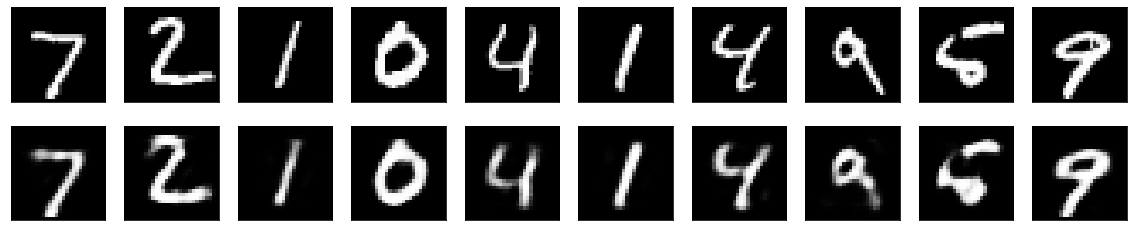

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
